DSCI 100 004

Laura Flannigan, Kaitlyn Harvie, Hannah Morstead, & Tony Tang 

<p style = "font-size:22pt"> Predicting Heart Disease from Multiple Demographic and Risk Factors Variables </p>

 **<p style = "font-size:18pt; font-style:bold"> Introduction </p>**

According to the World Health Organization, the leading cause of death worldwide is cardiovascular diseases (2021). However, heart disorders can be preventable, as research has revealed various risk factors in the development of heart disease. Yusuf et al. (2001) suggested that high blood pressure and increased LDL cholesterol levels show causal links to cardiovascular disease. Additionally, the presence of chest pain has been found to be associated with increased risk of long-term cardiovascular disease (Robson et al., 2015), as well as ECG abnormalities which are suggestive of an increased risk of heart disease (Whincup, 1995). Other variables, such as gender and age, contribute to risk factors (Mass & Appleman, 2010).


The dataset we will be using is the Cleveland Heart Disease dataset from the Cleveland Clinic Foundation (Detrano et al., 1988) derived from the UCL Machine Learning Repository. The dataset is made up of 303 observations of individuals at the Clevelent Clinic receiving angiography. Using this dataset will determine how accurately a K-Nearest Neighbors classification model correctly predicts the presence of heart disease for a new observation. The classification algorithm will use the following predictor varibles: age, sex, chest pain type, resting blood pressure, blood cholesterol levels, resting ECG results, and presence of exercise-indudced angina.

**<p style = "font-size:18pt; font-style:bold"> Preliminary Exploratory Data Analysis </p>**

To begin, the seed is set to ensure the model is reproducible. equired libaries were loaded and the Cleveland Heart Disease data set was read in — ensuring approporate and readable column names. The response variable (diagnosis) was mutated as a factor variable type to allow for future categorization of unknown observations. 

In [1]:
# Set the seed for the notebook, load required libraries, and set options.
set.seed(1248)
library(tidyverse)
library(tidymodels)
library(ggplot2)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 15, repr.plot.height = 4)

# Download and read the original dataset, mutating columns with factor variables to the correct type.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, "data/processed_cleveland.csv")
cleveland_data <- read_csv("data/processed_cleveland.csv", col_names = c("age", "sex", "cp_type", "resting_bp",
                           "cholesterol", "fasting_bs", "ECG_results", "max_pulse", "exercise_ang", "ST_depress",
                           "slope_ST", "fluoroscopy", "thal", "diagnosis"), na = "?") %>%
    mutate(diagnosis = as_factor(diagnosis))
cleveland_data

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

age,sex,cp_type,resting_bp,cholesterol,fasting_bs,ECG_results,max_pulse,exercise_ang,ST_depress,slope_ST,fluoroscopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1
38,1,3,138,175,0,0,173,0,0.0,1,NA,3,0


**age**: age in years   
**sex**: sex (1 = male; 0 = female)  
**cp_type**: chest pain type (1: typical angina; 2: atypical angina; 3: non-anginal pain; 4: asymptomatic)  
**resting_bp**: resting blood pressure upon admission to hospital (mm Hg)    
**cholesterol**: blood cholesterol content (mg/dl)  
**fasting_bs**: fasting blood sugar greater than 120 mg/dl (1 = true; 0 = false)  
**ECG_results**: resting ECG results (0: normal; 1: ST-T wave abnormality; 2: left ventricular hypertrophy)  
**max_pulse**: maximum heart rate achieved  
**exercise_ang**: exercise induced angina (1 = yes; 0 = no)  
**ST_depress**: ST depression induced by exercise relative to rest  
**slope_ST**: slope of the peak exercise ST segment (1: upsloping; 2: flat; 3: downsloping)  
**fluoroscopy**: # of major vessels (0-3) coloured by fluoroscopy  
**thal**: unknown variable with values 3 = normal, 6 = fixed defect, 7 = reversable defect  
**diagnosis**: diagnosis of heart disease (0 = healthy; 1-4 = increasing presence of heart disease)  

The outcomes 1 through 4 of the diagnosis variable all indicate the presence of heart disease, and the increasing numberical values signify the increasing severity of heart disease present. To simplify the prediction process, the diagnosis variable was mutated to ensure the outcome variable has only two possible categories: "healthy" and "presence of heart disease". 

In [2]:
#mutate diagnosis varible to have two categories (rather than 4)
cleveland_data <- cleveland_data %>%
    mutate(diagnosis = case_when(
    str_detect(diagnosis, "0")~ 0,
    str_detect(diagnosis, "1")~ 1,
    str_detect(diagnosis, "2")~ 1,
    str_detect(diagnosis, "3")~1,
    str_detect(diagnosis, "4")~1)) %>%
    mutate(cp_type = case_when(
    str_detect(cp_type, "1") ~ 1, 
    str_detect(cp_type, "2") ~ 1, 
    str_detect(cp_type, "3") ~ 1, 
    str_detect(cp_type, "4") ~ 0))

cleveland_data$diagnosis <- as.factor(cleveland_data$diagnosis)

cleveland_data
#should chest pain type be recoded?
#how to recode ECG results

age,sex,cp_type,resting_bp,cholesterol,fasting_bs,ECG_results,max_pulse,exercise_ang,ST_depress,slope_ST,fluoroscopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,0,160,286,0,2,108,1,1.5,2,3,3,1
67,1,0,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,0,130,131,0,0,115,1,1.2,2,1,7,1
57,0,1,130,236,0,2,174,0,0.0,2,1,3,1
38,1,1,138,175,0,0,173,0,0.0,1,NA,3,0


**age**: age in years   
**sex**: sex (1 = male; 0 = female)  
**cp_type**: chest pain type (0 = symptomatic, 1 = asymptomatic)  
**resting_bp**: resting blood pressure upon admission to hospital (mm Hg)    
**cholesterol**: blood cholesterol content (mg/dl)  
**ECG_results**: resting ECG results (0: normal; 1: ST-T wave abnormality; 2: left ventricular hypertrophy)  
**exercise_ang**: exercise induced angina (1 = yes; 0 = no)    
**diagnosis**: diagnosis of heart disease (0 = healthy, 1 = heart disease diagnosis)

Unneeded variables were removed, and the data with the remaining predictor variables was split into training and testing sets. The training set will be used to build a classification algorithm and predict the parameter with the highest prediction accuracy. The testing set will be used to inspect how well the model is able to predict a class (diagnosis) when given unseen data.

In [3]:
# Select the predictors we are interested in and the prediction class variable. Split into training and testing sets.
cleveland_data <- cleveland_data %>%
    select(age, sex, cp_type, resting_bp, cholesterol, ECG_results, exercise_ang, diagnosis)
cleveland_split <- initial_split(cleveland_data, prop = 3/4, strata = diagnosis)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)
cleveland_train

age,sex,cp_type,resting_bp,cholesterol,ECG_results,exercise_ang,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,2,0,0
67,1,0,160,286,2,1,1
41,0,1,130,204,2,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,0,130,131,0,1,1
57,0,1,130,236,2,0,1
38,1,1,138,175,0,0,0


A tibble with proportions of each diagnostic category allows us to determine if the classes are balanced within the training data set. The Cleveland training set appears to have relatively similar proportions of each outcome cateogry. 

In [4]:
# Create a tibble to summarize the number of entries in each class included in the training set.
class_count <- cleveland_train %>%
    group_by(diagnosis) %>%
    summarize(count = n())
class_count

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,count
<fct>,<int>
0,123
1,105


Here, the mean value of each predictor variable was determined. The "diagnosis" column was removed to ensure that only the mean of predictors were being looked at. 

In [5]:
# Create a tibble to summarize the average values of the numerical predictors.
predictors_mean <- cleveland_train %>%
    select(-diagnosis) %>%
    map_df(mean, na.rm = TRUE)
predictors_mean

age,sex,cp_type,resting_bp,cholesterol,ECG_results,exercise_ang
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.93421,0.6622807,0.5263158,132.9518,247.2368,1.035088,0.3157895


The mean of each predictor variable is found again, but here they are grouped by diagnosis. Then, the means of the numerical predictors are selected.

In [6]:
#determining means of each predictor variable in both diagnosis categories 
predictors_means <- cleveland_train %>%
    group_by(diagnosis)%>%
    summarize(mean_age = mean(age), 
             mean_sex = mean(sex), 
             mean_cp_type = mean(cp_type), 
             mean_resting_bp = mean(resting_bp), 
             mean_cholesterol = mean(cholesterol), 
             mean_ECG_results = mean(ECG_results), 
             mean_exercise_ang = mean(exercise_ang))
predictors_means

#selecting just the means of numerical predictors 
numerical_predictors <- cleveland_train %>%
    gather("variable", "value", age, resting_bp, cholesterol) %>%
    group_by(diagnosis, variable) %>%
    summarise(mean=mean(value))
numerical_predictors

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,mean_age,mean_sex,mean_cp_type,mean_resting_bp,mean_cholesterol,mean_ECG_results,mean_exercise_ang
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,53.08130,0.5528455,0.7560976,130.8049,245.1870,0.8861789,0.1219512
1,57.10476,0.7904762,0.2571429,135.4667,249.6381,1.2095238,0.5428571


`summarise()` regrouping output by 'diagnosis' (override with `.groups` argument)



diagnosis,variable,mean
<fct>,<chr>,<dbl>
0,age,53.08130
0,cholesterol,245.18699
0,resting_bp,130.80488
1,age,57.10476
1,cholesterol,249.63810
1,resting_bp,135.46667


Here, the mean of of the numerical predictors are plotted by diagnosis type using a bar graph. A "healthy" diagnosis is indicated by a green bar, and an "unhealthy" diagnosis is indicated by an orange bar.

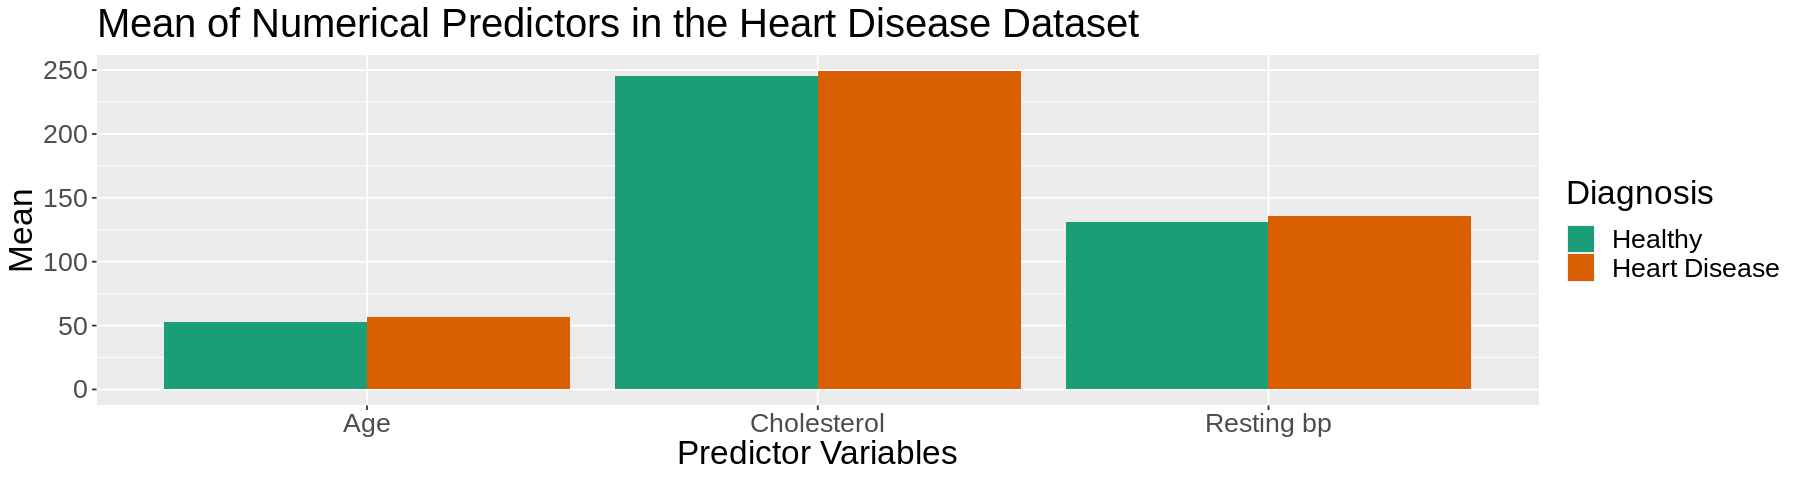

In [7]:
#plotting means of numerical predictors by diagnosis category 
predictor_numerical_plot <- numerical_predictors %>% 
    ggplot(aes(x = variable, y=mean, fill= factor(diagnosis,labels = c("Healthy", "Heart Disease")))) +
    geom_bar(alpha = 1, stat ="identity", position = "dodge") +
    scale_x_discrete(labels = c("Age", "Cholesterol", "Resting bp")) +
    labs(x = "Predictor Variables", y = "Mean", fill = "Diagnosis", title = "Mean of Numerical Predictors in the Heart Disease Dataset") +
    scale_fill_brewer(palette = "Dark2") +
    theme(text = element_text(size=20))
predictor_numerical_plot

#add numbers on top of bars

diagnosis,variable,value
<fct>,<chr>,<dbl>
0,sex,1
1,sex,1
0,sex,0
⋮,⋮,⋮
1,exercise_ang,1
1,exercise_ang,0
0,exercise_ang,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



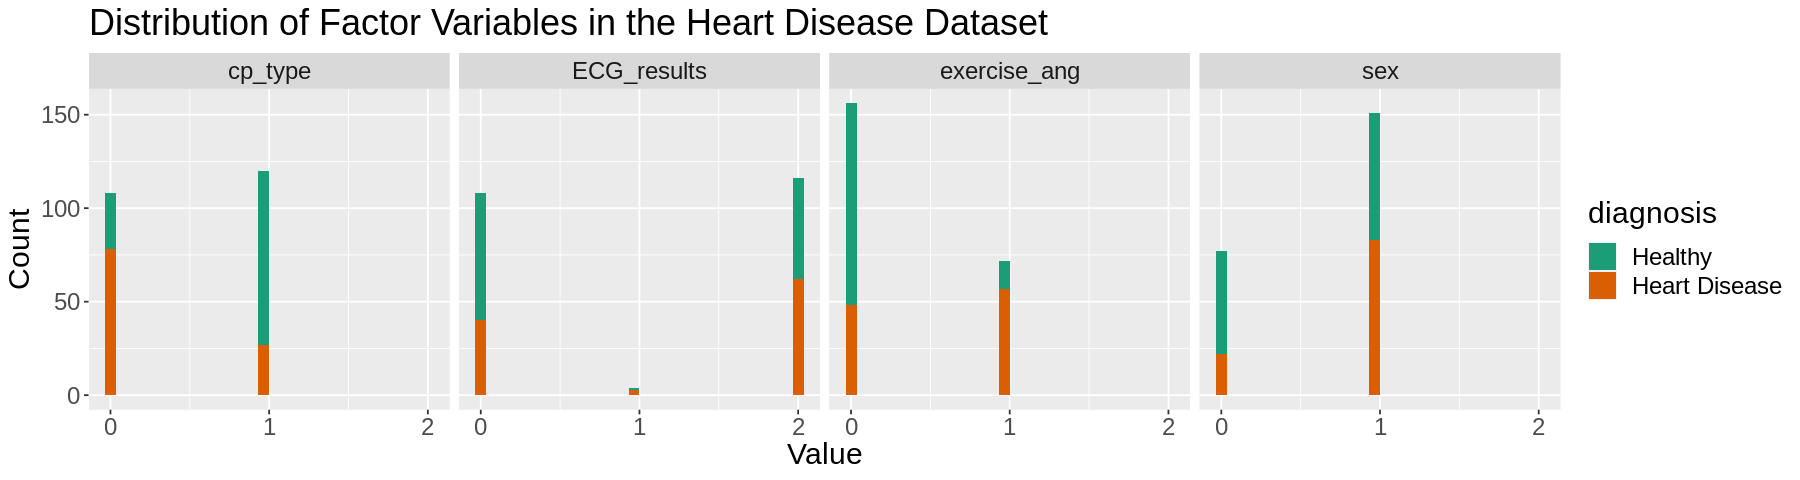

In [8]:
#selecting for factor variables and gathering values of each variable 
factor_predictors<- cleveland_train %>%
    select(-age, -resting_bp, -cholesterol) %>%
    gather("variable", "value", sex, cp_type, ECG_results, exercise_ang) %>%
    group_by(diagnosis, variable) 
   
factor_predictors

# Create a plot of the distributions of the factor predictors.
predictor_factor_plot <- ggplot(factor_predictors, aes(value, fill = factor(diagnosis, labels = c("Healthy", "Heart Disease")))) +
      geom_histogram() +
      facet_wrap(~c(variable), nrow = 1) +
      ggtitle("Distribution of Factor Variables in the Heart Disease Dataset") +
      labs(x = "Value", y = "Count", fill ="diagnosis") +
      scale_fill_brewer(palette = "Dark2") +
      scale_x_continuous(breaks = seq(0, 2, by = 1)) + 
      theme(text = element_text(size=18))
predictor_factor_plot

#re-label title of each graph 
#label x-axis 
#scale x-axis 0-1 after changing ECG 

**<p style = "font-size:18pt; font-style:bold"> Data Analysis </p>**

First of all, the training data is standardized. To make sure the data is consistent and to ensure each data type has the same scale, the data must be standardized and centered. This will establish that all the variables have an average of 0, and a standard deviation of 1. This ensures that different variables may be compared if needed. 

In [9]:
#Build recipe with predictor and outcome varibles, standardize training data 

cleveland_recipe <- recipe(diagnosis~ ., data=cleveland_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 
cleveland_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          7

Operations:

Scaling for all_predictors()
Centering for all_predictors()

A model specification is created. It is indicated that we want the straight-line distance, and that the computational engine we want to use is kknn.

In [10]:
#create a model specification
knn_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) %>%
    set_engine ("kknn") %>%
    set_mode ("classification")

Here, 5-fold cross validation is performed. 

In [11]:
#perform 5-fold cross validaion 
cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = diagnosis)

A workflow analysis is created to combine the new knn_tune model specification with the recipe. The tune_grid() function is used to fit the model for every paramater value. The collect_metrics() function aggregrates the standard error and the mean. All this is done on the training set, and cross validation is run on each validation split

In [12]:
#train model with the training data set and run cross validation on each validation split 
cleveland_results <- workflow() %>%
    add_recipe(cleveland_recipe) %>%
    add_model(knn_tune)%>%
    tune_grid(resamples = cleveland_vfold, grid = 10) %>%
    collect_metrics()

cleveland_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6974879,5,0.01688501,Model1
2,roc_auc,binary,0.7549683,5,0.01916573,Model1
3,accuracy,binary,0.7237681,5,0.02331507,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,binary,0.8289286,5,0.01793333,Model8
15,accuracy,binary,0.7326570,5,0.02162374,Model9
15,roc_auc,binary,0.8315952,5,0.01842408,Model9


Here, we determined the best value for K by plotting out the accuracy for each value of K. A line graph was used to visualize the relationship between the K-value and its accuracy at predicting a diagnosis. Just by looking a the plot, we can see that K = 3 and K = 4 have the highest accuracies. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6974879,5,0.01688501,Model1
3,accuracy,binary,0.7237681,5,0.02331507,Model2
4,accuracy,binary,0.7237681,5,0.02331507,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.741256,5,0.02696613,Model7
12,accuracy,binary,0.741256,5,0.02696613,Model8
15,accuracy,binary,0.732657,5,0.02162374,Model9


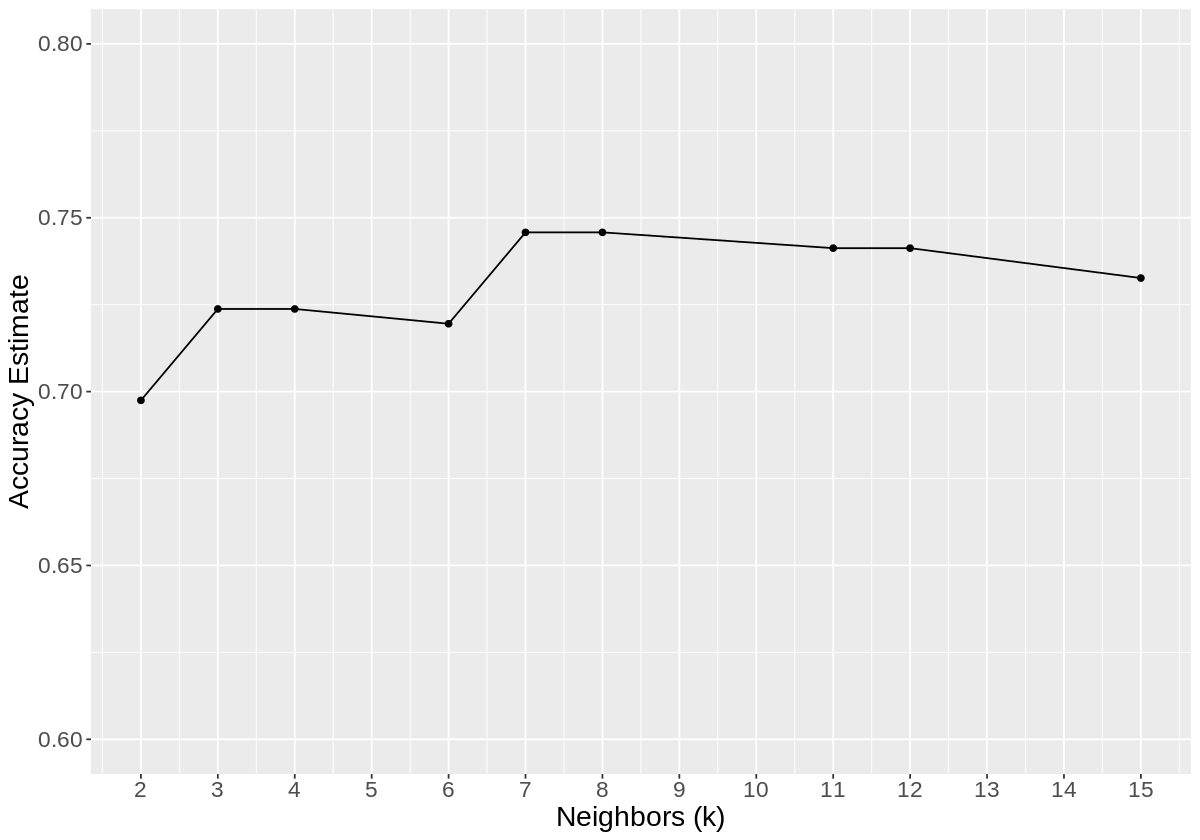

In [13]:
#select parameter with greatest accuracy 

accuracies <- cleveland_results %>%
    filter(.metric == "accuracy")
accuracies 

options(repr.plot.width = 10, repr.plot.height = 7)
accuracy_plot <- accuracies %>%
    ggplot(aes (x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs (x = "Neighbors (k)", y = "Accuracy Estimate") +
    theme(text = element_text(size=17)) +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) + 
    scale_y_continuous(limits = c(0.6, 0.8)) 
accuracy_plot

Visually, it appears that K = 3 and K = 4 have the same prediction accuracy, but is necessary to fully inspect which of the two has a higher accuracy. Here, the mean and K-values are selected and arranged in descending order. Now, we can see that K = 3 has the highest accuracy.

In [14]:
#selecting best parameter value 
knn_best <- accuracies %>% 
    select(mean, neighbors) %>%
    arrange(desc(mean))%>%
    slice(1)
knn_best

mean,neighbors
<dbl>,<int>
0.7457971,7


Another model specification is built, but this time we know that we must use K = 7. The training data is then fit with the new model specification. 

In [15]:
#build model specification with best value for K and fit training data with new model specification

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
    set_engine("kknn") %>%
    set_mode("classification")

cleveland_fit <- workflow() %>%
    add_recipe(cleveland_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = cleveland_train)
cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~7, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2587719
Best kernel: rectangular
Best k: 7

Finally, it is time to use the final model to predict on unseen data, that is, the testing set.

In [16]:
#Make predictions using testing data set 
cleveland_predictions <- predict(cleveland_fit, cleveland_test) %>%
    bind_cols(cleveland_test)
cleveland_predictions

cleveland_metrics <- cleveland_predictions %>%
    metrics(truth = diagnosis, estimate = .pred_class)
cleveland_metrics


cleveland_conf_mat <- cleveland_predictions %>%
    conf_mat(truth = diagnosis, estimate = .pred_class)
cleveland_conf_mat
  

.pred_class,age,sex,cp_type,resting_bp,cholesterol,ECG_results,exercise_ang,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,67,1,0,120,229,2,1,1
0,37,1,1,130,250,0,0,0
1,53,1,0,140,203,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,35,1,1,122,192,0,0,0
1,63,1,0,140,187,2,1,1
1,68,1,0,144,193,0,0,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7600000
kap,binary,0.5182013


          Truth
Prediction  0  1
         0 31  8
         1 10 26

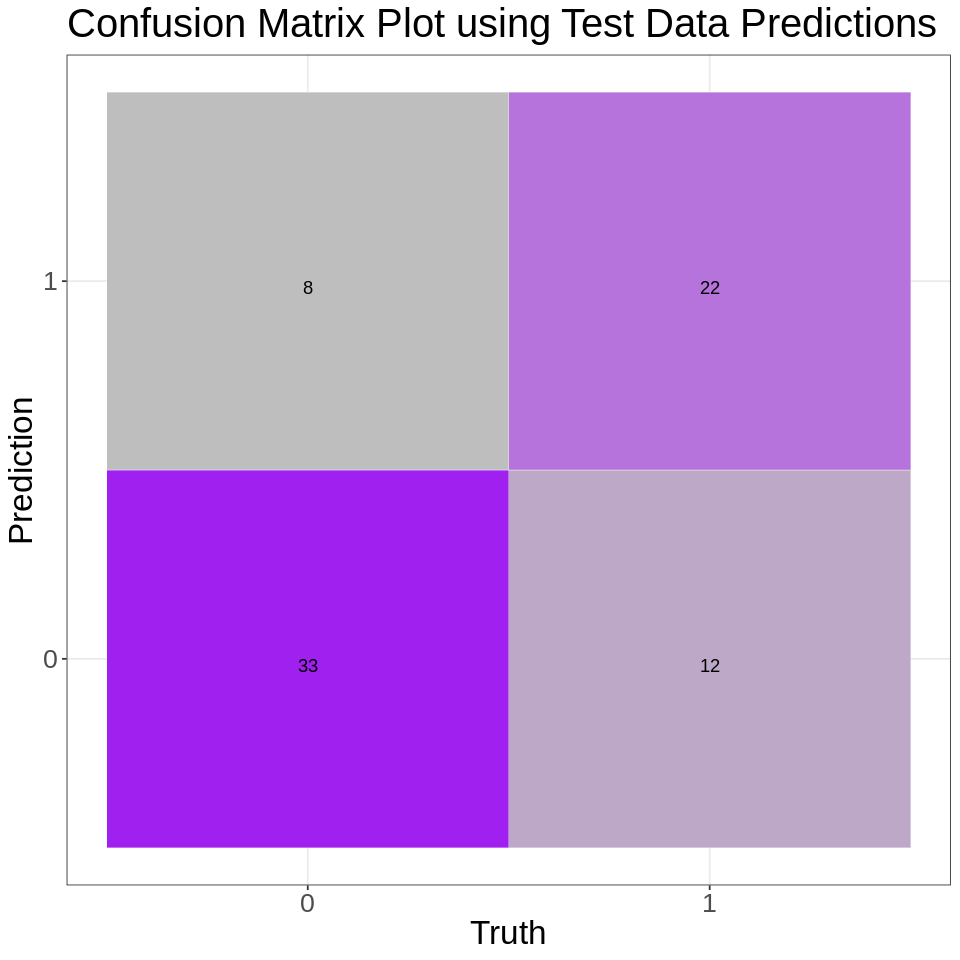

In [17]:
Truth <- factor(c(1, 1, 0, 0))
Prediction <- factor(c(0, 1, 0, 1))
Y <- c(12, 22, 33, 8)
df<- data.frame(Truth, Prediction, Y)

options(repr.plot.width = 8, repr.plot.height = 8)
cleveland_matrix_plot <- ggplot(data = df, mapping = aes(x = Truth, y = Prediction)) +
    geom_tile(aes(fill = Y), colour = "white") +
    geom_text(aes(label=sprintf("%1.0f", Y)), vjust=1) +
    scale_fill_gradient(low = "grey", high = "purple") +
    theme_bw() + theme(legend.position="none") +
    labs(x = "Truth", y = "Prediction", title="Confusion Matrix Plot using Test Data Predictions") +
    theme(text = element_text(size=20)) 
    
cleveland_matrix_plot




**<p style = "font-size:18pt; font-style:bold"> Discussion </p>**

**<p style = "font-size:18pt; font-style:bold"> References </p>**

Detrano, R., Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K. H., Lee, S., and Froelicher,V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. *The American Journal of Cardiology,* 46, 304-310. 

Maas, A. H. E. M. & Appelman, Y. E. A. (2011). Gender differences in coronary heart disease. *Netherlands Heart Journal,* 18, 589 - 602. https://doi.org/10.1007/s12471-010-0841-y

Robson, J., Ayerbe, L., Mathur, R., Addo, J., & Wragg, A. (2015). Clinical value of chest pain presentation and prodromes on the assessment of cardiovascular disease: a cohort study. *BJM Open,* 5, 1-6. https://doi.org/10.1136/bmjopen-2014-007251

Whincup, P. H., Wannamethee, G., Macfarlane, P. W., Walker, M. & Shaper, G. A. (1995). Resting electrocardiogram and risk of coronary heart disease in middle-ages British men. *Journal of Cardiovascular Risk,* 2, 533-543. https://doi.org/10.1177/174182679500200608

World Health Organization. (2021). *Cardiovascular Diseases (CVDs)*. Retreived from https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)


Yusuf, S., Reddy, S., Ounpuu, S. & Anand, S. (2001) Global Burden of Cardiovascular Diseases: Part I: General Considerations, the Epidemiologic Transition, Risk Factors, and Impact of Urbanization. *Circulation,* 104, 2746-2753. https://doi.org/10.1161/hc4601.099487
